In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.cluster import KMeans
import hdbscan


%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [2]:
def load_features(files):
    df = pd.read_csv('../dataset/train.csv', index_col=0, usecols=['id', 'target'])
    for file in files:
        df = df.merge(pd.read_csv(file, index_col=0), how='outer', left_index=True, right_index=True)
    return df

In [3]:
def add_clustering_features(df):
    kmeans_2 = KMeans(n_clusters=2, init='k-means++').fit(df)
    kmeans_3 = KMeans(n_clusters=3, init='k-means++').fit(df)
    kmeans_5 = KMeans(n_clusters=5, init='k-means++').fit(df)
    kmeans_10 = KMeans(n_clusters=10, init='k-means++').fit(df)
    kmeans_15 = KMeans(n_clusters=15, init='k-means++').fit(df)
    kmeans_50 = KMeans(n_clusters=50, init='k-means++').fit(df)
    kmeans_100 = KMeans(n_clusters=100, init='k-means++').fit(df)
    kmeans_200 = KMeans(n_clusters=200, init='k-means++').fit(df)
    kmeans_500 = KMeans(n_clusters=500, init='k-means++').fit(df)

    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
    cluster_labels = clusterer.fit_predict(df)

    df['kmeans_2'] = kmeans_2.labels_
    df['kmeans_3'] = kmeans_3.labels_
    df['kmeans_5'] = kmeans_5.labels_
    df['kmeans_10'] = kmeans_10.labels_
    df['kmeans_15'] = kmeans_15.labels_
    df['kmeans_50'] = kmeans_50.labels_
    df['kmeans_100'] = kmeans_100.labels_
    df['kmeans_200'] = kmeans_200.labels_
    df['kmeans_500'] = kmeans_500.labels_
    df['HDBScan'] = cluster_labels

In [4]:
full_model = load_features(['../features/features_basicas_texto.csv', '../features/features_basicas_keyword.csv', '../features/links_and_hashtags.csv', '../features/features_location.csv'])

model = full_model[full_model['target'].notnull()]

labels = model['target']
model = model.drop('target', axis=1)
add_clustering_features(model)

In [5]:
model.describe()

,word_count,unique_words_count,word_count_above_mean,unique_words_count_above_mean,char_count,char_count_above_mean,avg_word_length,subjectivity,polarity,neg,neu,pos,has_keyword,keyword_count,keyword_mean,encoded_keyword,has_insecure_link,has_secure_link,has_link,has_www,insecure_link_count,secure_link_count,link_count,has_hashtagh,hashtag_count,has_user_mentions,user_mentions_count,has_location,match_score,encoded_country,encoded_city,kmeans_2,kmeans_3,kmeans_5,kmeans_10,kmeans_15,kmeans_50,kmeans_100,HDBScan
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.0,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,9.608170,9.171023,0.516616,0.475108,51.748063,0.510311,5.390339,0.282619,-0.147014,0.481151,0.275581,0.243268,0.991987,49.718902,0.223959,0.429062,0.053461,0.473401,0.521608,0.001051,0.566006,0.054118,0.620123,0.231315,0.446999,0.267831,0.362406,0.0,62.110701,0.429140,0.438748,0.652437,1.022724,2.147511,3.607776,6.737423,21.049783,45.198214,0.347563
std,4.008664,3.700445,0.499757,0.499413,22.696155,0.499927,1.485600,0.327791,0.439501,0.499677,0.446836,0.429084,0.089160,4.836752,0.021787,0.273588,0.224966,0.499325,0.499566,0.032402,0.661818,0.229150,0.663930,0.421701,1.099841,0.442858,0.720097,0.0,45.990457,0.085053,0.114210,0.476228,0.807469,1.449960,2.783264,4.318113,13.142136,30.176029,0.476228
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.987900,0.000000,0.000000,0.000000,0.000000,13.000000,0.058559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,0.000000,0.000000,35.000000,0.000000,4.666667,0.000000,-0.510600,0.000000,0.000000,0.000000,1.000000,50.000000,0.225225,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.420188,0.420188,0.000000,0.000000,1.000000,1.000000,4.000000,8.000000,18.000000,0.000000
50%,10.000000,9.000000,1.000000,0.000000,52.000000,1.000000,5.333333,0.100000,0.000000,0.000000,0.000000,0.000000,1.000000,50.000000,0.225225,0.391304,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,96.420000,0.424917,0.429557,1.000000,1.000000,2.000000,3.000000,6.000000,24.000000,45.000000,0.000000
75%,13.000000,12.000000,1.000000,1.000000,69.000000,1.000000,6.000000,0.516667,0.000000,1.000000,1.000000,0.000000,1.000000,50.000000,0.225225,0.655172,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,100.000000,0.429626,0.465741,1.000000,2.000000,4.000000,6.000000,10.000000,31.000000,72.000000,1.000000
max,52.000000,24.000000,1.000000,1.000000,126.000000,1.000000,30.500000,1.000000,0.968200,1.000000,1.000000,1.000000,1.000000,87.000000,0.391892,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,4.000000,1.000000,13.000000,1.000000,8.000000,0.0,100.000000,1.000000,1.000000,1.000000,2.000000,4.000000,9.000000,14.000000,49.000000,99.000000,1.000000


# Feature Importance

In [6]:
def feature_importance(model, classifier):
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indexes = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(model.shape[1]):
        print(f"{f + 1}. feature {indexes[f]}: {model.columns[f]} ({importances[indexes[f]]})")
    print()
    plt.figure(figsize=(24,12))
    plt.title("Features por importancia")
    plt.bar(range(model.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
    plt.xticks(range(model.shape[1]), indexes)
    plt.xlim([-1, model.shape[1]])
    plt.show()

## Con Random Forest

In [7]:
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0,
                              class_weight ={1:1})
forest.fit(model, labels.values.ravel())

ExtraTreesClassifier(class_weight={1: 1}, n_estimators=500, random_state=0)

Feature ranking:
1. feature 15: word_count (0.19372403956032716)
2. feature 8: unique_words_count (0.058210319837684696)
3. feature 4: word_count_above_mean (0.054409155184695905)
4. feature 6: unique_words_count_above_mean (0.053093461341099685)
5. feature 30: char_count (0.052032489591889504)
6. feature 29: char_count_above_mean (0.050836358235232644)
7. feature 7: avg_word_length (0.04664742346907907)
8. feature 1: subjectivity (0.04165563600662847)
9. feature 0: polarity (0.0401332066624967)
10. feature 37: neg (0.03798758543170424)
11. feature 36: neu (0.03326567898576762)
12. feature 17: pos (0.028589738204206575)
13. feature 35: has_keyword (0.02337183394690898)
14. feature 18: keyword_count (0.020906429940376704)
15. feature 34: keyword_mean (0.020709456972736025)
16. feature 24: encoded_keyword (0.020071212792525037)
17. feature 28: has_insecure_link (0.019300691033449703)
18. feature 26: has_secure_link (0.018850648063185173)
19. feature 11: has_link (0.017302136699803867)
20

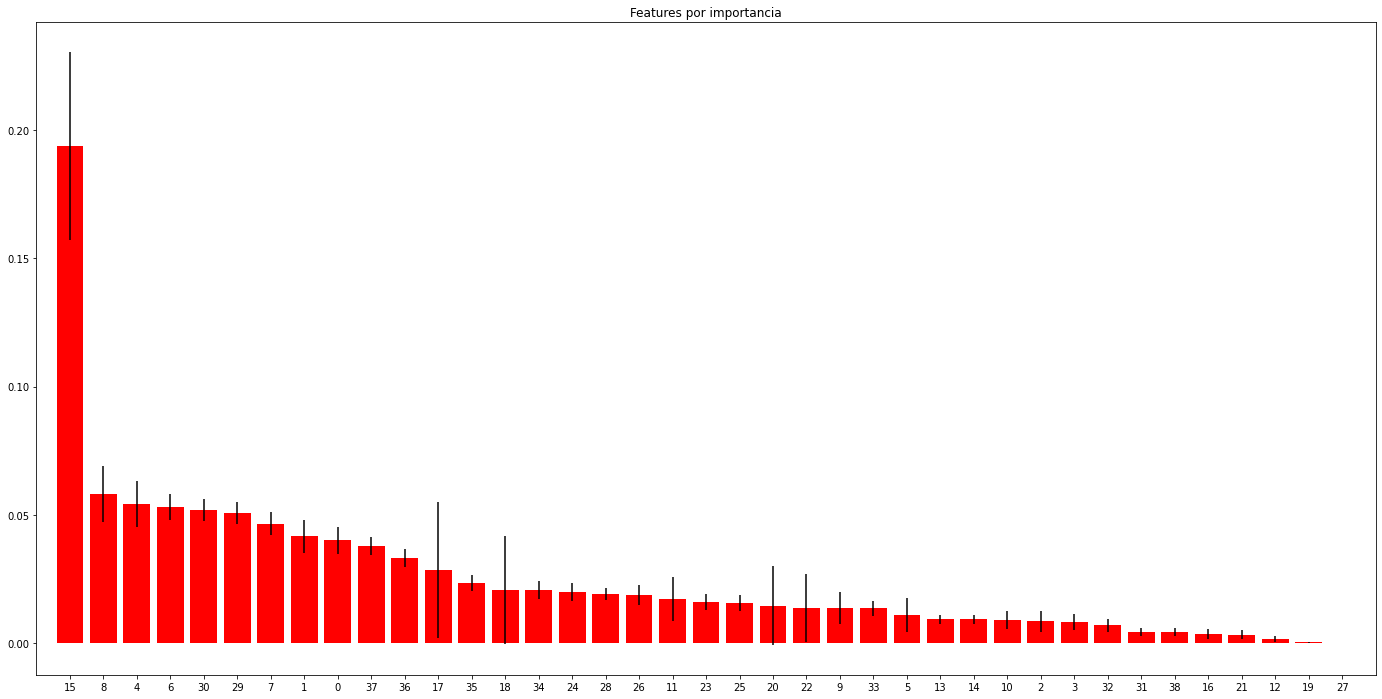

In [8]:
feature_importance(model, forest)

# Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(model, labels,test_size=0.2)
len(X_train),len(X_test),len(y_train),len(y_test)

(6090, 1523, 6090, 1523)

# Probando clasificadores

In [10]:
def try_classifier(classifier):
    classifier.fit(X_train, y_train.values.ravel())
    predictions = classifier.predict(X_test)
    predictions_with_prob = classifier.predict_proba(X_test)[:,1]
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'Verdaderos Negativos: {tn}')
    print(f'Falsos Negativos: {fn}')
    print(f'Verdaderos Positivos: {tp}')
    print(f'Falsos Positivos: {fp}')
    print()
    print(f'accuracy score: {accuracy_score(y_test, predictions)}')
    print(f'roc auc score: {roc_auc_score(y_test,  predictions_with_prob)}')
    print(f'f1 score: {f1_score(y_test,  predictions)}')
    print()
    fig, axs = plt.subplots(3)
    fig.set_size_inches(10,20)
    plt.subplots_adjust(hspace=0.2)
    xgb.plot_importance(xgb_classifier, ax=axs[0], importance_type='weight', title='Feature Importance (weight)', xlabel='weight', show_values=False)
    xgb.plot_importance(xgb_classifier, ax=axs[1], importance_type='gain', title='Feature Importance (gain)', xlabel='gain', show_values=False)
    xgb.plot_importance(xgb_classifier, ax=axs[2], importance_type='cover', title='Feature Importance (cover)', xlabel='cover', show_values=False)
    plt.show()
    return classifier

## XGBoost

In [19]:
# grid search para encontrar hiperparametros

#xgb_classifier = GridSearchCV(
#    xgb.XGBClassifier(),
#    {
#        'n_estimators' :[600, 650, 700, 750, 800],
#        'learning_rate': [ 0.075, 0.08, 0.085, 0.9],
#        'scale_pos_weight': [1.25, 1.3, 1.35]
#    },
#    scoring="f1",
#    n_jobs=-1,
#    refit=True
#)
#xgb_classifier.fit(X_train, y_train.values.ravel())

#xgb_classifier.best_params_

{'learning_rate': 0.08, 'n_estimators': 700, 'scale_pos_weight': 1.25}

Verdaderos Negativos: 640
Falsos Negativos: 159
Verdaderos Positivos: 520
Falsos Positivos: 204

accuracy score: 0.7616546290216678
roc auc score: 0.8374787986235682
f1 score: 0.7412687099073415



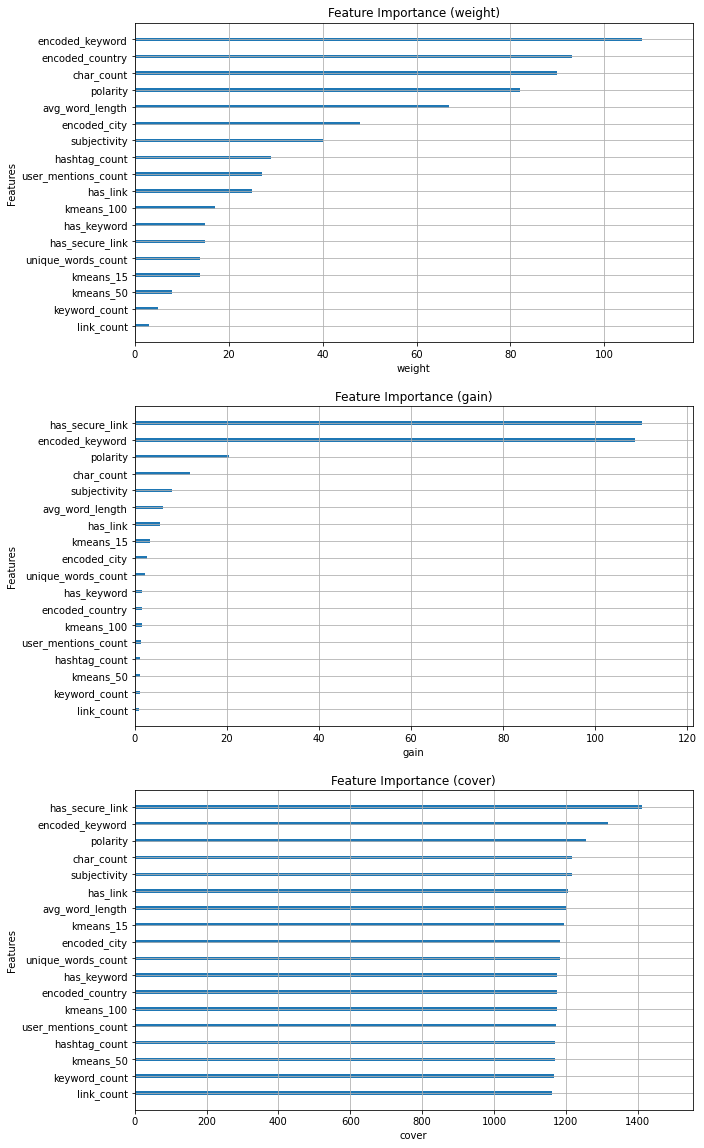

In [29]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=1,
    learning_rate=0.08,
    n_estimators=700,
    scale_pos_weight=1.25
)

xgb_classifier = try_classifier(xgb_classifier)


## LightGBM

Verdaderos Negativos: 631
Falsos Negativos: 166
Verdaderos Positivos: 513
Falsos Positivos: 213

accuracy score: 0.7511490479317138
roc auc score: 0.830222343982299
f1 score: 0.7302491103202846



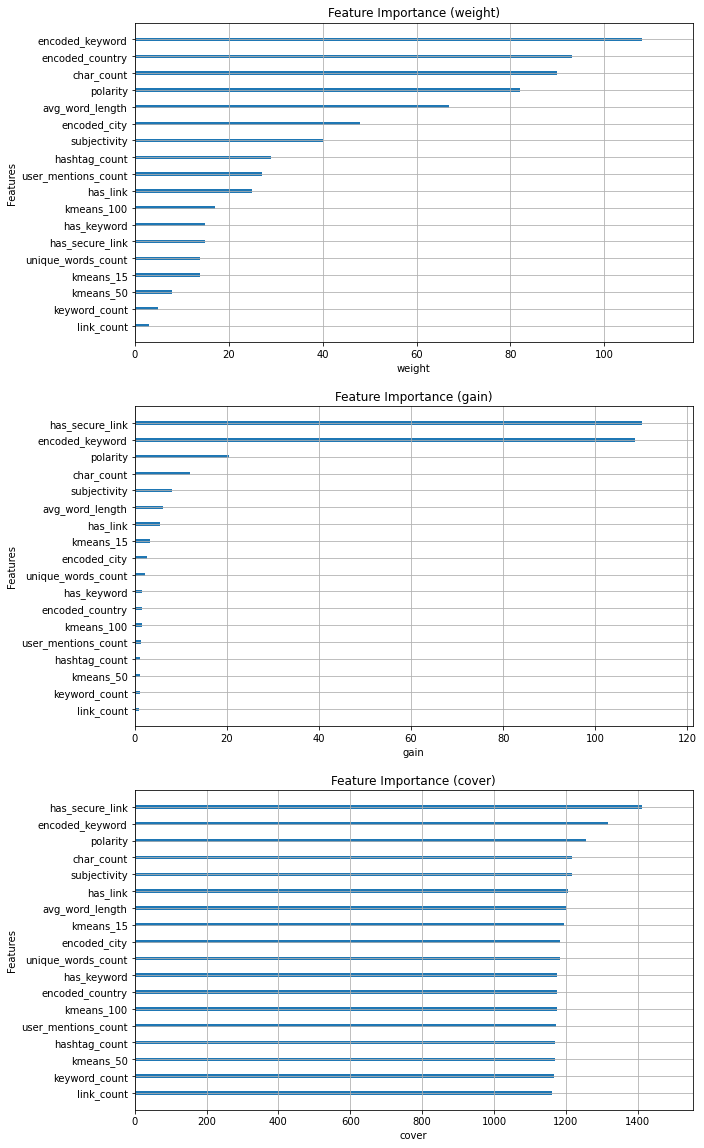

In [30]:
lgbm_classifier = lgb.LGBMClassifier(   
    objective='binary',
    boosting='goss',
    scale_pos_weight=1.3,
    n_estimators=700,
    learning_rate=0.008,
    max_depth=1, 
    num_threads=8,        
)

lgbm_classifier = try_classifier(lgbm_classifier)

## Random Forest

Verdaderos Negativos: 589
Falsos Negativos: 201
Verdaderos Positivos: 478
Falsos Positivos: 255

accuracy score: 0.7005909389363099
roc auc score: 0.7863634142766405
f1 score: 0.6770538243626063



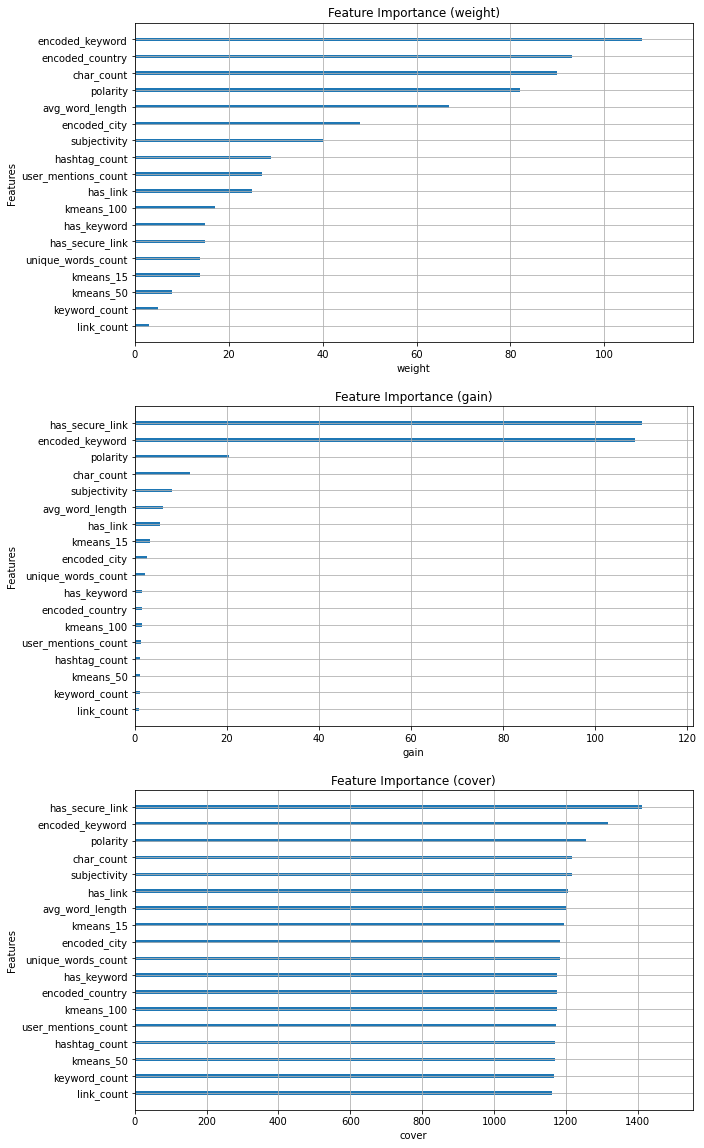

In [31]:
rf_classifier = RandomForestClassifier(
    criterion= 'entropy',
    max_depth= 1,
    n_estimators=700,
    max_features= 'auto',
    class_weight={1:1.3},
    n_jobs=-1
)
rf_classifier = try_classifier(rf_classifier)

## Catboost

Verdaderos Negativos: 638
Falsos Negativos: 159
Verdaderos Positivos: 520
Falsos Positivos: 206

accuracy score: 0.7603414313854235
roc auc score: 0.8378967187598154
f1 score: 0.7402135231316727



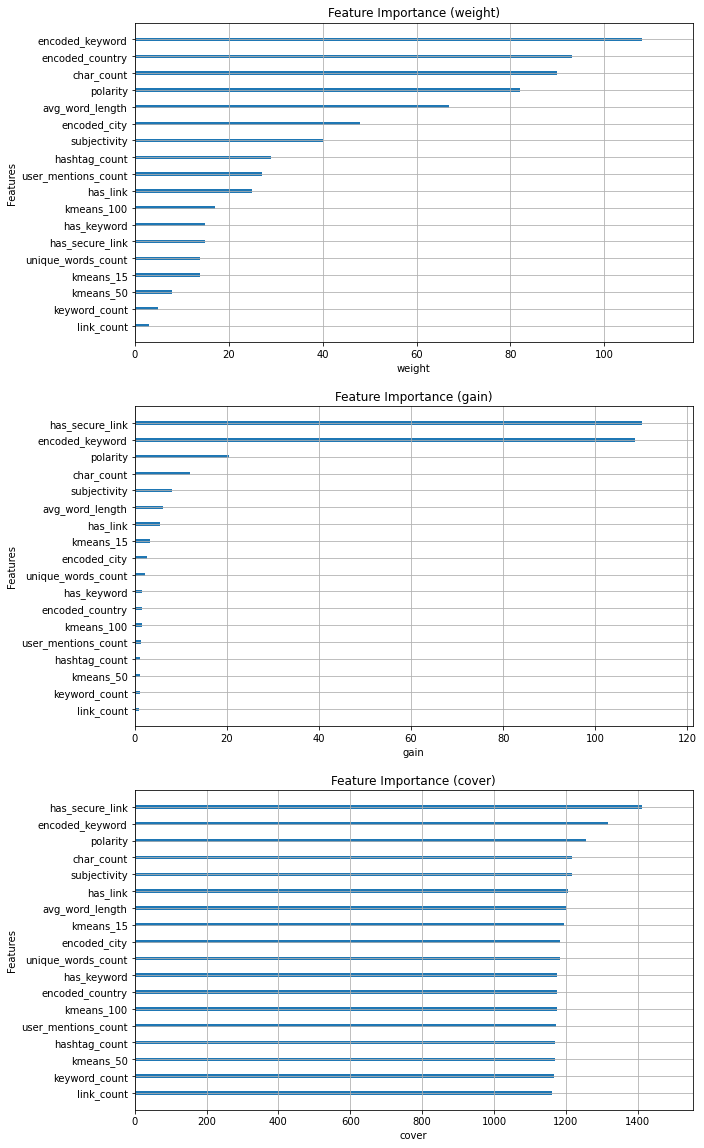

In [32]:
catboost_classifier = CatBoostClassifier(
    class_weights=[1, 1.3],
    logging_level='Silent',
    thread_count=8,
    depth=1,
    n_estimators=700,
    learning_rate=0.08
)

catboost_classifier = try_classifier(catboost_classifier)

# Prepare predictions

In [ ]:
# train with all dataset
X_train = full_model[full_model['target'].notnull()].drop('target')
add_clustering_features(X_train)
y_train = full_model[full_model['target'].notnull()]['target'].values.ravel()
xgb_classifier.fit(X_train, y_train)

In [ ]:
test = full_model[full_model['target'].isnull()]
test = test.drop('target', axis=1) add_clustering_features

In [ ]:
predictions = xgb_classifier.predict(test).astype(int)

In [ ]:
result = pd.DataFrame(data={'id': test.index, 'target': predictions})

In [ ]:
now = datetime.now(tz=None).strftime('%Y-%m-%dT%H-%M-%S')
result.to_csv(f'../predictions/prediction_{now}.csv', encoding='utf-8', index=False)